In [1]:
import math
import time
import pandas as pd
import numpy as np
import scanpy as sc
import scipy
from scipy.sparse import csr_array
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import style
import glob

from sklearn.neighbors import LocalOutlierFactor
from skimage import morphology, transform
from tifffile import imwrite

import os
os.environ['R_HOME'] = '/usr/lib/R'
os.chdir('/laune_zfs/scratch/peter/f_active/paper_23/') # laune

random_seed = 42
np.random.seed(random_seed)
from tqdm import tqdm


In [2]:
# adata = sc.read_h5ad('input/adata.h5ad') # aws
adata = sc.read_h5ad('input/02_stereoseq_qc/adata/adata.h5ad') # laune
# sc.pp.subsample(adata, n_obs=10000)

adata.obsm['spatial'] = adata.obs[['x', 'y']].to_numpy()
adata.layers['counts'] = adata.X.copy()

d_adata = {}

for count, x in enumerate(adata.obs['sample_name'].unique()):
    d_adata[x] = adata[adata.obs['sample_name'] == x,].copy()

In [3]:
for k,v in d_adata.items():
    coords = v.obsm['spatial']

    clf = LocalOutlierFactor(n_neighbors=200, n_jobs=-1)
    clf.fit_predict(coords)
    clf.negative_outlier_factor_

    cutoff = -1.3
    keep = clf.negative_outlier_factor_ > cutoff
    remove = clf.negative_outlier_factor_ < cutoff
    
    print('Removed from ' + k + ': ' + str(np.sum(remove)))
    v.obs['keep'] = keep.astype('str')
    d_adata[k] = v[keep, :].copy()

Removed from OLD_OVX_1: 5
Removed from OLD_OVX_2: 17
Removed from OLD_OVX_3: 7
Removed from OLD_OVX_4: 8
Removed from OLD_OVX_5: 10
Removed from OLD_WT_1: 14
Removed from OLD_WT_2: 20
Removed from OLD_WT_3: 43
Removed from OLD_WT_4: 35
Removed from OLD_WT_5: 2
Removed from YOUNG_OVX_1: 68
Removed from YOUNG_OVX_2: 29
Removed from YOUNG_OVX_3: 64
Removed from YOUNG_OVX_4: 11
Removed from YOUNG_WT_1: 14
Removed from YOUNG_WT_2: 18
Removed from YOUNG_WT_3: 129
Removed from YOUNG_WT_4: 436


In [4]:
adata.obs.groupby('sample_name').size()

/tmp/ipykernel_4090946/4181580196.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('sample_name').size()


sample_name
OLD_OVX_1      26133
OLD_OVX_2      25232
OLD_OVX_3      22694
OLD_OVX_4      22809
OLD_OVX_5      27399
OLD_WT_1       21567
OLD_WT_2       19403
OLD_WT_3       21200
OLD_WT_4       20209
OLD_WT_5       22746
YOUNG_OVX_1    21027
YOUNG_OVX_2    24428
YOUNG_OVX_3    22084
YOUNG_OVX_4    17023
YOUNG_WT_1     20851
YOUNG_WT_2     23331
YOUNG_WT_3     27544
YOUNG_WT_4     29722
dtype: int64

In [5]:
# sc.set_figure_params(figsize=(12,12))
# sc.pl.spatial(d_adata['OLD_WT_2'], color='keep', spot_size=80)

<Axes: xlabel='n_genes_by_counts', ylabel='sample_name'>

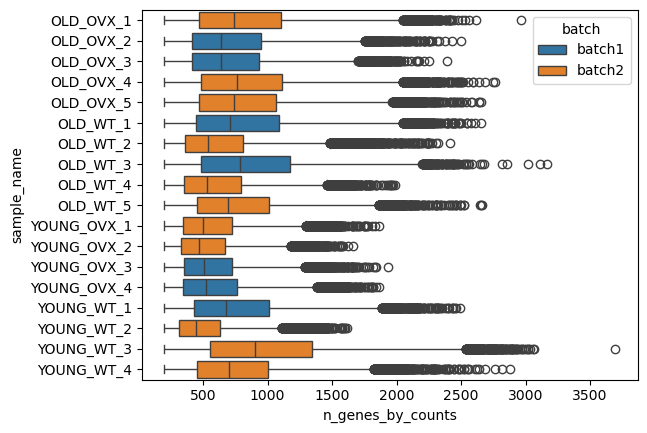

In [6]:
sns.boxplot(data = adata.obs, 
              x = 'n_genes_by_counts', 
              y = 'sample_name', 
           hue='batch')

# Write images to determine required rotation angle in imageJ

In [7]:
for k,v in d_adata.items():
    print(k)
    coords = v.obsm['spatial']
    row = coords[:, 0]
    col = coords[:, 1]
    data = np.arange(1, v.shape[0]+1)
    arr = csr_array((data, (row, col))).toarray()
    arr_bin = arr > 0
    arr_bin_dilated = morphology.binary_dilation(arr_bin, footprint=np.ones((10,10)))
    imwrite('input/03_rotation/' + k + '_binary.tif', arr_bin_dilated)

OLD_OVX_1
OLD_OVX_2
OLD_OVX_3
OLD_OVX_4
OLD_OVX_5
OLD_WT_1
OLD_WT_2
OLD_WT_3
OLD_WT_4
OLD_WT_5
YOUNG_OVX_1
YOUNG_OVX_2
YOUNG_OVX_3
YOUNG_OVX_4
YOUNG_WT_1
YOUNG_WT_2
YOUNG_WT_3
YOUNG_WT_4


# Rotate

In [7]:
def rotate(p, origin=(0, 0), degrees=0):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)
    
d_rotation = {
    'OLD_OVX_1': 59,
    'OLD_OVX_2': -2, 
    'OLD_OVX_3': -4,
    'OLD_OVX_4': -45,
    'OLD_OVX_5': -141,
    'OLD_WT_1': 94,
    'OLD_WT_2': 33,
    'OLD_WT_3': 1,
    'OLD_WT_4': 93,
    'OLD_WT_5': -138,
    'YOUNG_OVX_1': -53,
    'YOUNG_OVX_2': -144, 
    'YOUNG_OVX_3': -88,
    'YOUNG_OVX_4': 87,
    'YOUNG_WT_1': -93,
    'YOUNG_WT_2': 132,
    'YOUNG_WT_3': -150,
    'YOUNG_WT_4': 53
}

for k,v in tqdm(d_adata.items()):
    v = d_adata[k].copy()
    coords = v.obsm['spatial']
    row = coords[:, 0]
    col = coords[:, 1]
    # data = np.arange(1, v.shape[0]+1)
    # arr = csr_array((data, (row, col))).toarray()
    # arr_bin = arr > 0
    origin = (np.round(row.max() / 2).astype('int'), np.round(col.max() / 2).astype('int'))
    new_points = rotate(coords, origin=origin, degrees=90-d_rotation[k]).astype('int')

    min_row = new_points[:, 0].min()
    min_col = new_points[:, 1].min()
    new_points[:, 0] = new_points[:, 0] - min_row
    new_points[:, 1] = new_points[:, 1] - min_col

    d_adata[k].obsm['spatial_orig'] = d_adata[k].obsm['spatial'].copy()
    d_adata[k].obsm['spatial'] = new_points
    
    df = pd.DataFrame(d_adata[k].obsm['spatial'].astype('int'), columns = ['x', 'y'])
    d_adata[k].obs['x'] = df['x'].to_list()
    d_adata[k].obs['y'] = df['y'].to_list()
    df = pd.DataFrame(d_adata[k].obsm['spatial_orig'].astype('int'), columns = ['x', 'y'])
    d_adata[k].obs['x_orig'] = df['x'].to_list()
    d_adata[k].obs['y_orig'] = df['y'].to_list()

    del(d_adata[k].obsm)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:07<00:00,  2.37it/s]


In [8]:
names = list(d_adata.keys())
adata = d_adata[names[0]]

for name in tqdm(names[1:]):
    adata = ad.concat([adata, d_adata[name]])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:54<00:00,  3.18s/it]


/home/peter/mambaforge/envs/paper_rotate_stereoseq/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/peter/mambaforge/envs/paper_rotate_stereoseq/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/peter/mambaforge/envs/paper_rotate_stereoseq/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


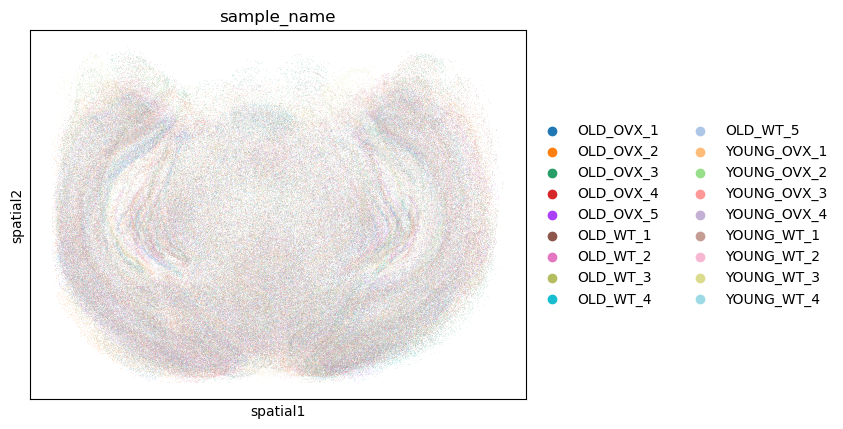

In [9]:
adata.obsm['spatial'] = adata.obs[['x', 'y']].to_numpy()
sc.pl.embedding(adata, basis='spatial', color='sample_name')

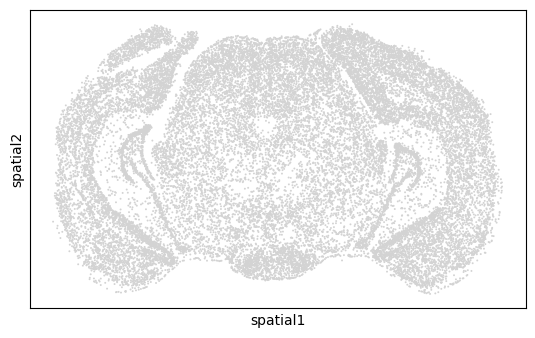

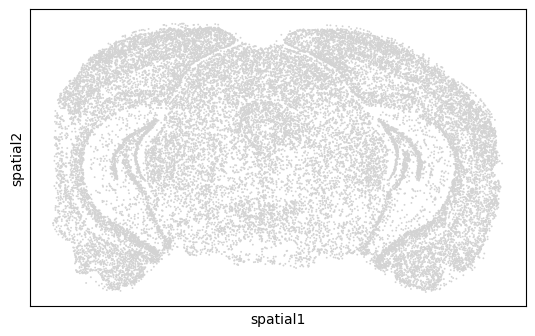

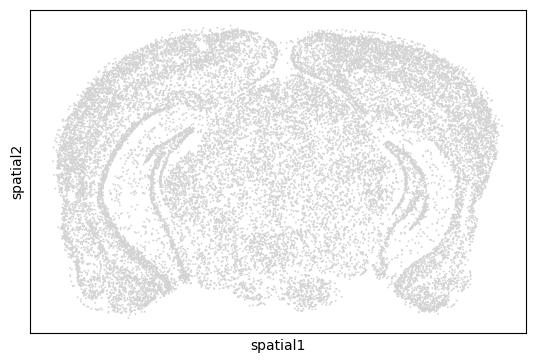

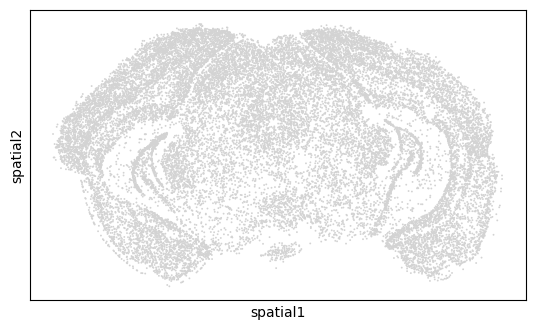

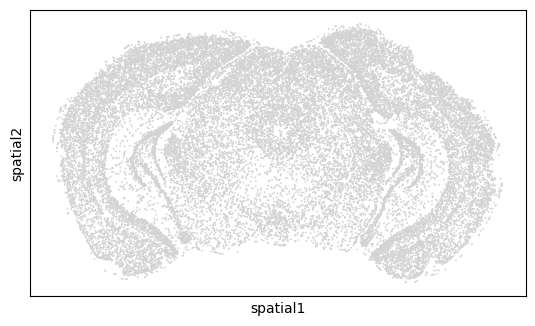

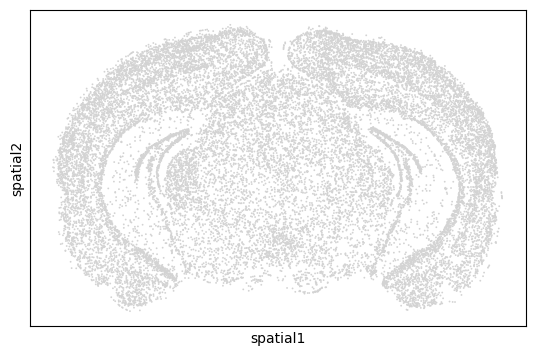

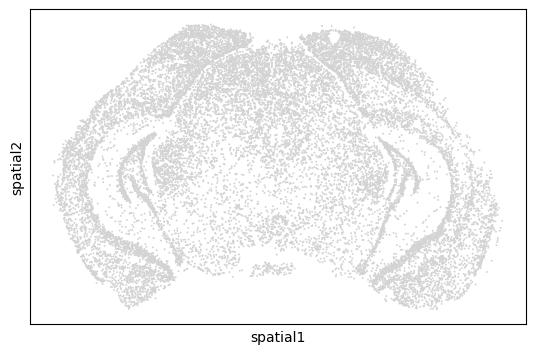

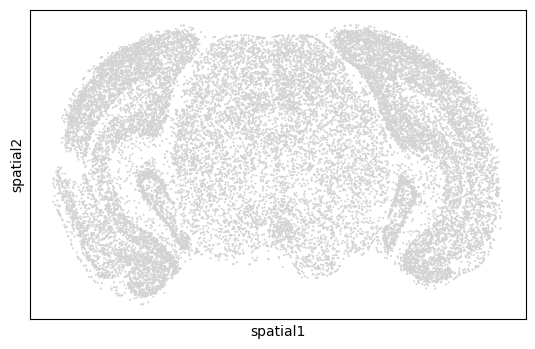

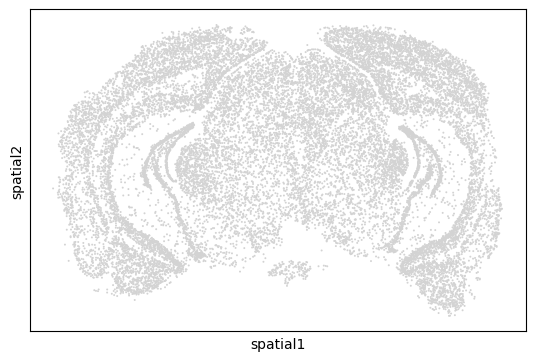

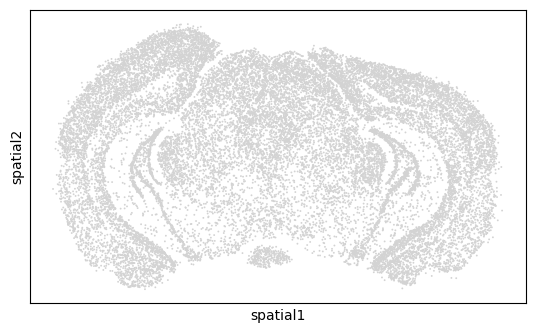

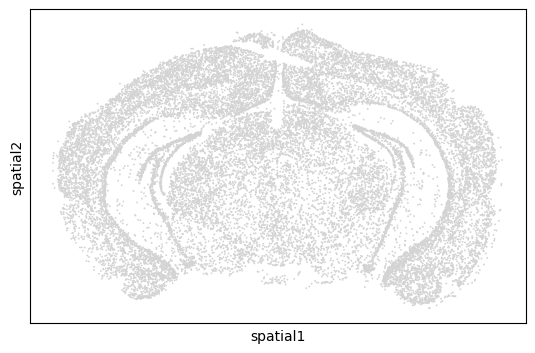

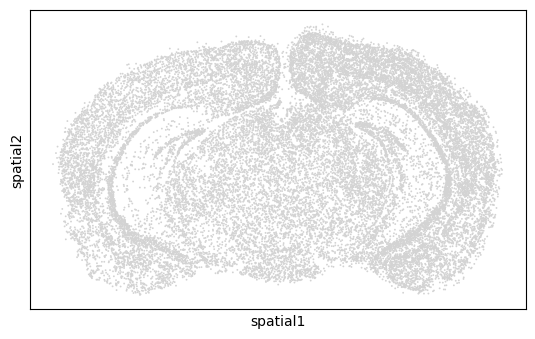

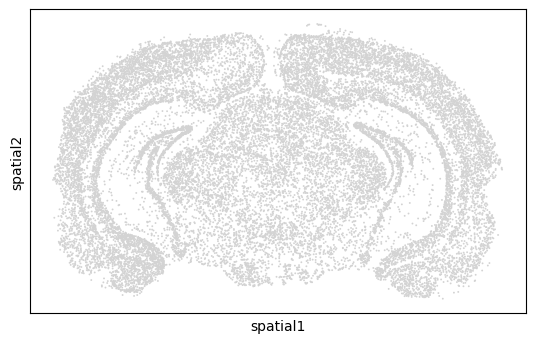

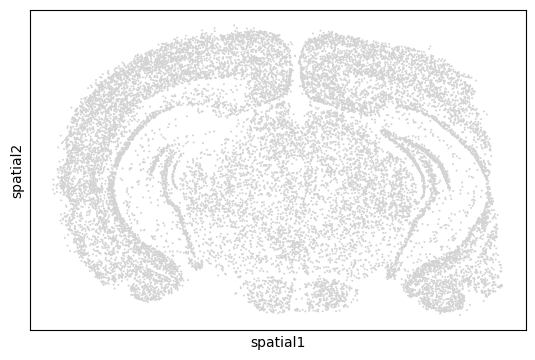

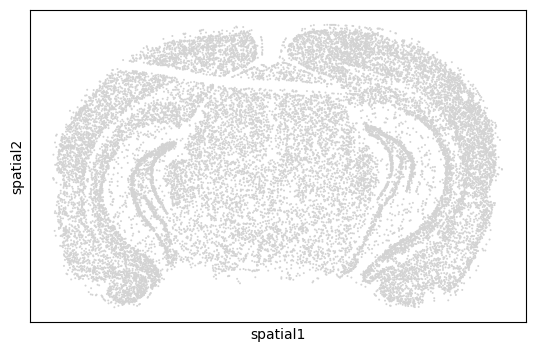

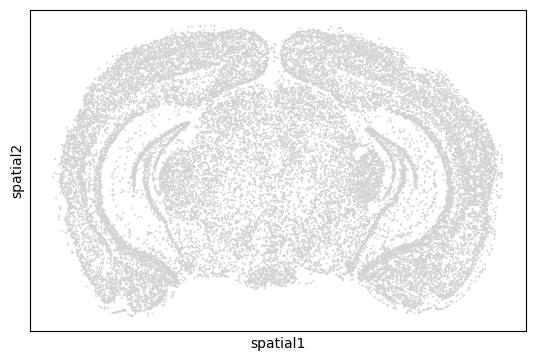

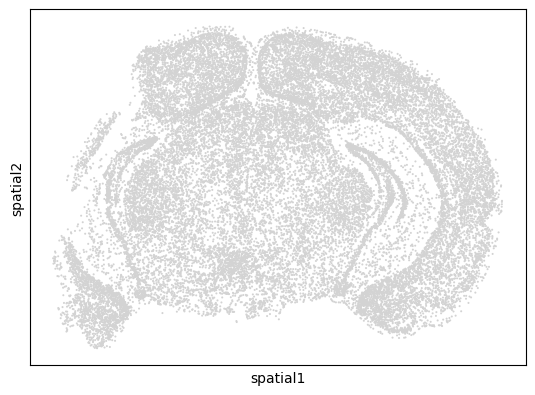

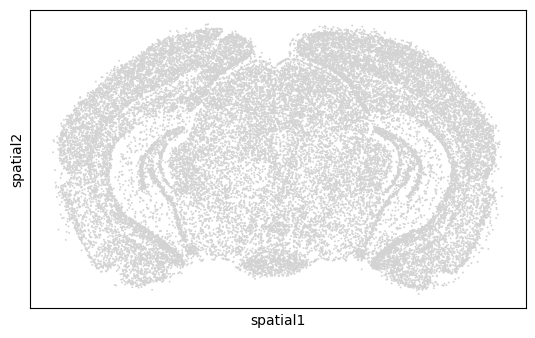

In [10]:
for k,v in d_adata.items():
    v.obsm['spatial'] = v.obs[['x', 'y']].to_numpy()
    sc.pl.spatial(v, spot_size=80)

In [11]:
adata.obsm['spatial'] = adata.obs[['x', 'y']].to_numpy()
adata.write_h5ad('input/03_rotation/adata_rotated_cleaned.h5ad')